<a href="https://colab.research.google.com/github/dmw1998/Case_Study_Log/blob/main/actual_prob4PCE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [165]:
# !pip install casadi

In [166]:
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

## To build OCP by parts

In [167]:
# Time and discretization
tf = 40        # final time [sec]
N = 40         # number of control intervals
dt = tf / N    # time step

# Aircraft physical constants
m = 4662                # mass [lb sec^2 / ft]
g = 32.172              # gravity [ft/sec^2]
delta = 0.03491         # thrust inclination angle [rad]

# Thrust model coefficients: T = A0 + A1*V + A2*V^2
A0 = 0.4456e5           # [lb]
A1 = -0.2398e2          # [lb sec / ft]
A2 = 0.1442e-1          # [lb sec^2 / ft^2]

# Aerodynamic model
rho = 0.2203e-2         # air density [lb sec^2 / ft^4]
S = 0.1560e4            # reference surface area [ft^2]

# Lift coefficient: C_L = C0 + C1 * alpha
C0 = 0.7125             # baseline lift coefficient
C1 = 6.0877             # AOA lift slope [1/rad]

# Lift/drag model optional extensions (if needed)
C2 = -9.0277            # [rad^-2] — e.g., for moment or drag extension

# Angle of attack & control constraints
umax = 0.05236          # max control input (rate of change of alpha) [rad/sec]
alphamax = 0.3          # max angle of attack [rad]

# Wind model 1 parameters (piecewise smooth wind)
a = 200                 # x transition midpoint [ft]
b = 4500                # second transition point [ft]
c = 2000                # transition smoothing width [ft]

# Wind model 2 & 3 parameters (polynomial form)
d = -8.02881e-8         # polynomial coeff [sec^-1 ft^-2]
e = 6.28083e-11         # polynomial coeff [sec^-1 ft^-3]

# Wind model 3 beta (smoothing) parameters
beta0 = 0.4             # initial beta value (approximate)
beta_dot0 = 0.2         # initial beta rate
sigma = 3               # time to reach beta = 1 [sec]

# Wind model 3 coefficients (A(x) = B0 + B1 * γ + B2 * γ^2)
B0 = 0.1552
B1 = 0.12369            # [1/rad]
B2 = 2.4203             # [1/rad^2]

# Cost function / target altitude
hR = 1000               # reference altitude [ft]
h_star = 1000           # used in some wind models

# Auxiliary
eps = 1e-6              # to avoid division by zero in V

# Scaling factors (used if normalizing states)
xscale = 10000          # [ft]
hscale = 1000           # [ft]
Vscale = 240            # [ft/sec]
gammascale = 0.1        # [rad]
alphascale = 0.3        # [rad]
uscale = 0.05           # [rad/sec]

# k
k_value = 1.0           # wind intensity scaling (used for UQ)

In [168]:
# ========== CasADi Opti Setup ==========
opti = ca.Opti()
x = opti.variable(N+1)
h = opti.variable(N+1)
V = opti.variable(N+1)
gamma = opti.variable(N+1)
alpha = opti.variable(N+1)
u = opti.variable(N)

In [169]:
# Smooth transition (C∞)
def Smooth(x, x0, x1):
    t = (x - x0) / (x1 - x0)
    return ca.if_else(x < x0, 0,
           ca.if_else(x > x1, 1,
           6*t**5 - 15*t**4 + 10*t**3))

# A(x) from Eq. (14)
def A_piecewise(x_):
    A1 = -50 + a * x_**3 + b * x_**4
    A2 = 0.025 * (x_ - 2300)
    A3 = 50 - a * (4600 - x_)**3 - b * (4600 - x_)**4
    A4 = 50

    s1 = Smooth(x_, 480, 520)
    s2 = Smooth(x_, 4080, 4120)
    s3 = Smooth(x_, 4580, 4620)

    B12 = (1 - s1)*A1 + s1*A2
    B23 = (1 - s2)*A2 + s2*A3
    B34 = (1 - s3)*A3 + s3*A4

    return ca.if_else(x_ <= 500, B12,
           ca.if_else(x_ <= 4100, B23,
           ca.if_else(x_ <= 4600, B34, A4)))

def wind_x(x_):
    return k_value * A_piecewise(x_)

# B(x) from Eq. (16)
def B_piecewise(x_):
    B1 = d * x_**3 + e * x_**4
    B2 = -51 * ca.exp(-c * (x_ - 2300)**4)
    B3 = d * (4600 - x_)**3 + e * (4600 - x_)**4
    B4 = 0

    s1 = Smooth(x_, 480, 520)
    s2 = Smooth(x_, 4080, 4120)
    s3 = Smooth(x_, 4580, 4620)

    B12 = (1 - s1)*B1 + s1*B2
    B23 = (1 - s2)*B2 + s2*B3
    B34 = (1 - s3)*B3 + s3*B4

    return ca.if_else(x_ <= 500, B12,
           ca.if_else(x_ <= 4100, B23,
           ca.if_else(x_ <= 4600, B34, B4)))

def wind_h(x_, h_):
    return k_value * h_ / h_star * B_piecewise(x_)

In [170]:
x_sym = ca.MX.sym("x")
h_sym = ca.MX.sym("h")

Wx_expr = wind_x(x_sym)
Wh_expr = wind_h(x_sym, h_sym)

dWx_dx_fun = ca.Function("dWx_dx", [x_sym], [ca.gradient(Wx_expr, x_sym)])
dWh_dx_fun = ca.Function("dWh_dx", [x_sym, h_sym], [ca.gradient(Wh_expr, x_sym)])
dWh_dh_fun = ca.Function("dWh_dh", [x_sym, h_sym], [ca.gradient(Wh_expr, h_sym)])

In [171]:
def aircraft_ode(X, u_):
    x_, h_, V_, gamma_, alpha_ = ca.vertsplit(X)

    T = A0 + A1 * V_ + A2 * V_**2
    D = 0.1 * rho * S * V_**2
    L = 0.5 * rho * S * (C0 + C1 * alpha_) * V_**2

    Wx = wind_x(x_)     # horizontal wind
    Wh = wind_h(x_, h_) # vertical wind

    V_safe = ca.fmax(V_, 1e-3)  # for safety

    x_dot = V_ * ca.cos(gamma_) + Wx
    h_dot = V_ * ca.sin(gamma_) + Wh

    dWx_dx_val = dWx_dx_fun(x_)[0]
    dWh_dx_val = dWh_dx_fun(x_, h_)[0]
    dWh_dh_val = dWh_dh_fun(x_, h_)[0]

    Wx_dot = dWx_dx_val * x_dot
    Wh_dot = dWh_dx_val * x_dot + dWh_dh_val * h_dot

    V_dot = (
        T / m * ca.cos(alpha_ + delta)
        - D / m
        - g * ca.sin(gamma_)
        - (Wx_dot * ca.cos(gamma_) + Wh_dot * ca.sin(gamma_))
    )

    gamma_dot = (
        T / (m * V_safe) * ca.sin(alpha_ + delta)
        + L / (m * V_safe)
        - g / V_safe * ca.cos(gamma_)
        + (1 / V_safe) * (Wx_dot * ca.sin(gamma_) - Wh_dot * ca.cos(gamma_))
    )

    alpha_dot = u_

    return ca.vertcat(x_dot, h_dot, V_dot, gamma_dot, alpha_dot)


In [172]:
# ========== Integrator ==========
X_sym = ca.MX.sym("X", 5)
u_sym = ca.MX.sym("u")
rhs = aircraft_ode(X_sym, u_sym)
intg = ca.integrator("intg", "rk", {"x": X_sym, "p": u_sym, "ode": rhs}, {"tf": dt})

In [173]:
# ========== Constraints ==========
opti.subject_to(x[0] == 0)
opti.subject_to(h[0] == 600)
opti.subject_to(V[0] == 239.7)
opti.subject_to(gamma[0] == -0.03925)
opti.subject_to(alpha[0] == 0.1283)
opti.subject_to(gamma[-1] == -0.05236)

for i in range(N):
    Xk = ca.vertcat(x[i], h[i], V[i], gamma[i], alpha[i])
    Uk = u[i]
    Xk_end = intg(x0=Xk, p=Uk)["xf"]
    X_next = ca.vertcat(x[i+1], h[i+1], V[i+1], gamma[i+1], alpha[i+1])
    opti.subject_to(X_next == Xk_end)
    opti.subject_to(ca.fabs(u[i]) <= umax)
    opti.subject_to(ca.fabs(alpha[i]) <= alphamax)

In [174]:
# ========== Objective ==========
J = dt * ca.sumsqr(ca.vertcat(*[(hR - h[i])**3 for i in range(N+1)]))  # or (hR - h[i])**6
opti.minimize(J)

In [175]:
# ========== Initial Guess ==========
opti.set_initial(x, ca.linspace(0, 10000, N+1))
opti.set_initial(h, ca.linspace(600, 1000, N+1))
opti.set_initial(V, 239.7)
opti.set_initial(gamma, -0.03925)
opti.set_initial(alpha, 0.1283)
opti.set_initial(u, 0)

In [ ]:
# ========== Solver ==========
opti.solver('ipopt', {}, {
    'max_iter': 1000,
    'tol': 1e-6,
    'print_level': 0,
    'linear_solver': 'mumps',
    'hessian_approximation': 'limited-memory'
})

sol = opti.solve()

In [129]:
res = {
        "x": sol.value(x),
        "h": sol.value(h),
        "V": sol.value(V),
        "gamma": sol.value(gamma),
        "alpha": sol.value(alpha),
        "u": sol.value(u),
        "J": sol.value(J),
    }

NameError: name 'sol' is not defined

## Visualization winds

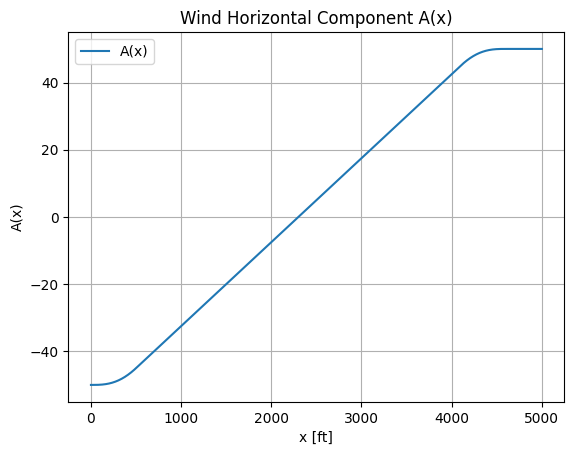

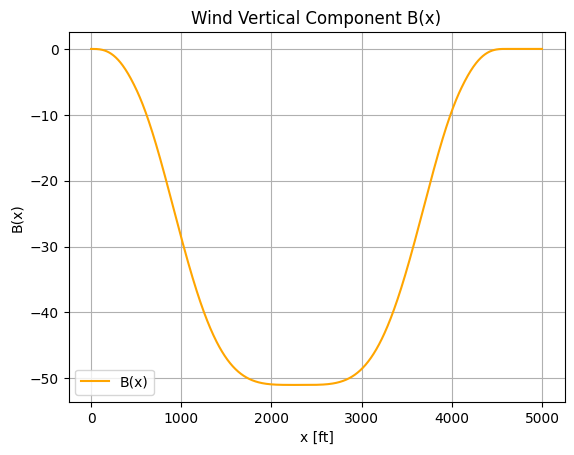

In [144]:
# Plot the wind model A(x) and B(x) to help diagnose the NaN source
def A_piecewise(x, a, b):
    A1 = -50 + a * x**3 + b * x**4
    A2 = 0.025 * (x - 2300)
    A3 = 50 - a * (4600 - x)**3 - b * (4600 - x)**4
    A4 = 50

    def smooth(x, x0, x1):
        t = (x - x0) / (x1 - x0)
        return np.where(x < x0, 0, np.where(x > x1, 1, 6*t**5 - 15*t**4 + 10*t**3))

    s1 = smooth(x, 480, 520)
    s2 = smooth(x, 4080, 4120)
    s3 = smooth(x, 4580, 4620)

    B12 = (1 - s1) * A1 + s1 * A2
    B23 = (1 - s2) * A2 + s2 * A3
    B34 = (1 - s3) * A3 + s3 * A4

    return np.where(x <= 500, B12,
           np.where(x <= 4100, B23,
           np.where(x <= 4600, B34, A4)))

def B_piecewise(x, d, e, c):
    B1 = d * x**3 + e * x**4
    B2 = -51 * np.exp(np.minimum(-c * (x - 2300)**4, 30))  # clip to avoid inf
    B3 = d * (4600 - x)**3 + e * (4600 - x)**4
    B4 = 0

    def smooth(x, x0, x1):
        t = (x - x0) / (x1 - x0)
        return np.where(x < x0, 0, np.where(x > x1, 1, 6*t**5 - 15*t**4 + 10*t**3))

    s1 = smooth(x, 480, 520)
    s2 = smooth(x, 4080, 4120)
    s3 = smooth(x, 4580, 4620)

    B12 = (1 - s1) * B1 + s1 * B2
    B23 = (1 - s2) * B2 + s2 * B3
    B34 = (1 - s3) * B3 + s3 * B4

    return np.where(x <= 500, B12,
           np.where(x <= 4100, B23,
           np.where(x <= 4600, B34, B4)))

x_vals = np.linspace(0, 5000, 1000)
a, b = 6e-8, -4e-11
c = -np.log(25 / 30.6) * 1e-12
d, e = -8.02881e-8, 6.28083e-11

A_vals = A_piecewise(x_vals, a, b)
B_vals = B_piecewise(x_vals, d, e, c)

plt.figure()
plt.plot(x_vals, A_vals, label="A(x)")
plt.title("Wind Horizontal Component A(x)")
plt.xlabel("x [ft]")
plt.ylabel("A(x)")
plt.grid()
plt.legend()

plt.figure()
plt.plot(x_vals, B_vals, label="B(x)", color="orange")
plt.title("Wind Vertical Component B(x)")
plt.xlabel("x [ft]")
plt.ylabel("B(x)")
plt.grid()
plt.legend()

plt.show()

## Solve OCP with $q=6$, RK

In [177]:
def solve_ocp(k_value):
    # ========== Parameters ==========
    tf = 40
    N = 40
    dt = tf / N

    # Aircraft parameters
    m = 4662
    g = 32.172
    delta = 0.03491
    A0 = 0.4456e5
    A1 = -0.2398e2
    A2 = 0.1442e-1
    rho = 0.2203e-2
    S = 0.1560e4
    C0 = 0.7125
    C1 = 6.0877
    umax = 0.05236
    alphamax = 0.3

    # Wind model parameters
    a = 6e-8
    b = -4e-11
    c = -np.log(25 / 30.6) * 1e-12
    d = -8.02881e-8
    e = 6.28083e-11
    h_star = 1000
    eps = 1e-6
    hR = 1000

    # ========== CasADi Opti Setup ==========
    opti = ca.Opti()
    x = opti.variable(N+1)
    h = opti.variable(N+1)
    V = opti.variable(N+1)
    gamma = opti.variable(N+1)
    alpha = opti.variable(N+1)
    u = opti.variable(N)

    # ========== Wind model ==========
    def Smooth(x, x0, x1):
        t = (x - x0) / (x1 - x0)
        return ca.if_else(x < x0, 0,
               ca.if_else(x > x1, 1, 6*t**5 - 15*t**4 + 10*t**3))

    def A_piecewise(x_):
        A1 = -50 + a * x_**3 + b * x_**4
        A2 = 0.025 * (x_ - 2300)
        A3 = 50 - a * (4600 - x_)**3 - b * (4600 - x_)**4
        A4 = 50
        s1 = Smooth(x_, 480, 520)
        s2 = Smooth(x_, 4080, 4120)
        s3 = Smooth(x_, 4580, 4620)
        B12 = (1 - s1)*A1 + s1*A2
        B23 = (1 - s2)*A2 + s2*A3
        B34 = (1 - s3)*A3 + s3*A4
        return ca.if_else(x_ <= 500, B12,
               ca.if_else(x_ <= 4100, B23,
               ca.if_else(x_ <= 4600, B34, A4)))

    def B_piecewise(x_):
        B1 = d * x_**3 + e * x_**4
        # B2 = -51 * ca.exp(-c * (x_ - 2300)**4)
        B2 = -51 * ca.exp(ca.fmin(-c * (x_ - 2300)**4, 30))
        B3 = d * (4600 - x_)**3 - e * (4600 - x_)**4
        B4 = 0
        s1 = Smooth(x_, 480, 520)
        s2 = Smooth(x_, 4080, 4120)
        s3 = Smooth(x_, 4580, 4620)
        B12 = (1 - s1)*B1 + s1*B2
        B23 = (1 - s2)*B2 + s2*B3
        B34 = (1 - s3)*B3 + s3*B4
        return ca.if_else(x_ <= 500, B12,
               ca.if_else(x_ <= 4100, B23,
               ca.if_else(x_ <= 4600, B34, B4)))

    def wind_x(x_, k_):
        return k_ * A_piecewise(x_)

    def wind_h(x_, h_, k_):
        # return k_ * h_ / h_star * B_piecewise(x_)
        h_safe = ca.fmax(h_, 10.0)
        return k_ * h_safe / h_star * B_piecewise(x_)


    # Derivatives for V̇, γ̇
    x_sym = ca.MX.sym("x")
    h_sym = ca.MX.sym("h")
    Wx_expr = wind_x(x_sym, k_value)
    Wh_expr = wind_h(x_sym, h_sym, k_value)
    dWx_dx_fun = ca.Function("dWx_dx", [x_sym], [ca.gradient(Wx_expr, x_sym)])
    dWh_dx_fun = ca.Function("dWh_dx", [x_sym, h_sym], [ca.gradient(Wh_expr, x_sym)])
    dWh_dh_fun = ca.Function("dWh_dh", [x_sym, h_sym], [ca.gradient(Wh_expr, h_sym)])

    # ========== ODE Function ==========
    def aircraft_ode(X, u_):
        x_, h_, V_, gamma_, alpha_ = ca.vertsplit(X)
        T = A0 + A1 * V_ + A2 * V_**2
        D = 0.5 * rho * S * V_**2
        L = 0.5 * rho * S * (C0 + C1 * alpha_) * V_**2
        Wx = wind_x(x_, k_value)
        Wh = wind_h(x_, h_, k_value)
        V_safe = ca.fmax(V_, 1e-3)

        x_dot = V_ * ca.cos(gamma_) + Wx
        h_dot = V_ * ca.sin(gamma_) + Wh

        dWx_dx_val = dWx_dx_fun(x_)[0]
        dWh_dx_val = dWh_dx_fun(x_, h_)[0]
        dWh_dh_val = dWh_dh_fun(x_, h_)[0]

        Wx_dot = dWx_dx_val * x_dot
        Wh_dot = dWh_dx_val * x_dot + dWh_dh_val * h_dot

        V_dot = T / m * ca.cos(alpha_ + delta) - D / m - g * ca.sin(gamma_) - (Wx_dot * ca.cos(gamma_) + Wh_dot * ca.sin(gamma_))
        gamma_dot = T / (m * V_safe) * ca.sin(alpha_ + delta) + L / (m * V_safe) - g / V_safe * ca.cos(gamma_) + (1 / V_safe) * (Wx_dot * ca.sin(gamma_) - Wh_dot * ca.cos(gamma_))
        alpha_dot = u_

        return ca.vertcat(x_dot, h_dot, V_dot, gamma_dot, alpha_dot)

    # ========== Integrator ==========
    X_sym = ca.MX.sym("X", 5)
    u_sym = ca.MX.sym("u")
    rhs = aircraft_ode(X_sym, u_sym)
    intg = ca.integrator("intg", "rk", {"x": X_sym, "p": u_sym, "ode": rhs}, {"tf": dt})

    # ========== Constraints ==========
    opti.subject_to(x[0] == 0)
    opti.subject_to(h[0] == 600)
    opti.subject_to(V[0] == 239.7)
    opti.subject_to(gamma[0] == -0.03925)
    opti.subject_to(alpha[0] == 0.1283)
    opti.subject_to(gamma[-1] == -0.05236)

    for i in range(N):
        Xk = ca.vertcat(x[i], h[i], V[i], gamma[i], alpha[i])
        Uk = u[i]
        Xk_end = intg(x0=Xk, p=Uk)["xf"]
        X_next = ca.vertcat(x[i+1], h[i+1], V[i+1], gamma[i+1], alpha[i+1])
        opti.subject_to(X_next == Xk_end)
        opti.subject_to(ca.fabs(u[i]) <= umax)
        opti.subject_to(ca.fabs(alpha[i]) <= alphamax)

    # ========== Objective ==========
    J = dt * ca.sumsqr(ca.vertcat(*[(hR - h[i])**3 for i in range(N+1)]))  # or (hR - h[i])**6
    # J = dt * ca.sumsqr(ca.vertcat(*[(hR - h[i]) for i in range(N+1)]))
    # J = dt * ca.sumsqr(h - hR)
    opti.minimize(J)

    # ========== Initial Guess ==========
    opti.set_initial(x, ca.linspace(0, 10000, N+1))
    opti.set_initial(h, ca.linspace(600, 1000, N+1))
    opti.set_initial(V, 239.7)
    opti.set_initial(gamma, -0.01)
    opti.set_initial(alpha, 0.02)
    opti.set_initial(u, 0)

    # ========== Solver ==========
    p_opts = {"expand": True}
    s_opts = {
        "max_iter": 1000,
        "tol": 1e-6,
        "print_level": 5,
        "linear_solver": "mumps",
        "hessian_approximation": "limited-memory",
    }
    opti.solver("ipopt", p_opts, s_opts)


    # sol = opti.solve()
    try:
        sol = opti.solve()
    except RuntimeError as e:
        opti.debug.show_infeasibilities()
        raise e


    return {
        "x": sol.value(x),
        "h": sol.value(h),
        "V": sol.value(V),
        "gamma": sol.value(gamma),
        "alpha": sol.value(alpha),
        "u": sol.value(u),
        "J": sol.value(J),
    }


In [ ]:
result = solve_ocp(k_value=1.0)

In [ ]:
plt.figure()
plt.plot(result["x"], result["h"])
plt.xlabel("x (horizontal position)")
plt.ylabel("h (altitude)")
plt.title("Flight trajectory k = 1.0")
plt.grid()
plt.show()

## $q = 2$, cvodes

In [94]:
def solve_ocp(k_value):
    tf = 40
    N = 40
    dt = tf / N

    m = 4662
    g = 32.172
    delta = 0.03491
    A0 = 0.4456e5
    A1 = -0.2398e2
    A2 = 0.1442e-1
    rho = 0.2203e-2
    S = 0.1560e4
    C0 = 0.7125
    C1 = 6.0877
    umax = 0.05236
    alphamax = 0.3

    a = 6e-8
    b = -4e-11
    c = -np.log(25 / 30.6) * 1e-12
    d = -8.02881e-8
    e = 6.28083e-11
    h_star = 1000
    eps = 1e-6
    hR = 1000

    opti = ca.Opti()
    x = opti.variable(N+1)
    h = opti.variable(N+1)
    V = opti.variable(N+1)
    gamma = opti.variable(N+1)
    alpha = opti.variable(N+1)
    u = opti.variable(N)

    def Smooth(x, x0, x1):
        t = (x - x0) / (x1 - x0 + eps)
        return ca.if_else(x < x0, 0,
               ca.if_else(x > x1, 1, 6*t**5 - 15*t**4 + 10*t**3))

    def A_piecewise(x_):
        A1 = -50 + a * x_**3 + b * x_**4
        A2 = 0.025 * (x_ - 2300)
        A3 = 50 - a * (4600 - x_)**3 - b * (4600 - x_)**4
        A4 = 50
        s1 = Smooth(x_, 480, 520)
        s2 = Smooth(x_, 4080, 4120)
        s3 = Smooth(x_, 4580, 4620)
        B12 = (1 - s1)*A1 + s1*A2
        B23 = (1 - s2)*A2 + s2*A3
        B34 = (1 - s3)*A3 + s3*A4
        return ca.if_else(x_ <= 500, B12,
               ca.if_else(x_ <= 4100, B23,
               ca.if_else(x_ <= 4600, B34, A4)))

    def B_piecewise(x_):
        B1 = d * x_**3 + e * x_**4
        B2 = -51 * ca.exp(ca.fmin(-c * (x_ - 2300)**4, 30))  # capped exponent
        B3 = d * (4600 - x_)**3 + e * (4600 - x_)**4
        B4 = 0
        s1 = Smooth(x_, 480, 520)
        s2 = Smooth(x_, 4080, 4120)
        s3 = Smooth(x_, 4580, 4620)
        B12 = (1 - s1)*B1 + s1*B2
        B23 = (1 - s2)*B2 + s2*B3
        B34 = (1 - s3)*B3 + s3*B4
        return ca.if_else(x_ <= 500, B12,
               ca.if_else(x_ <= 4100, B23,
               ca.if_else(x_ <= 4600, B34, B4)))

    def wind_x(x_, k_):
        return k_ * A_piecewise(x_)

    def wind_h(x_, h_, k_):
        h_safe = ca.fmax(h_, 10.0)
        return k_ * h_safe / h_star * B_piecewise(x_)

    x_sym = ca.MX.sym("x")
    h_sym = ca.MX.sym("h")
    Wx_expr = wind_x(x_sym, k_value)
    Wh_expr = wind_h(x_sym, h_sym, k_value)
    dWx_dx_fun = ca.Function("dWx_dx", [x_sym], [ca.gradient(Wx_expr, x_sym)])
    dWh_dx_fun = ca.Function("dWh_dx", [x_sym, h_sym], [ca.gradient(Wh_expr, x_sym)])
    dWh_dh_fun = ca.Function("dWh_dh", [x_sym, h_sym], [ca.gradient(Wh_expr, h_sym)])

    def aircraft_ode(X, u_):
        x_, h_, V_, gamma_, alpha_ = ca.vertsplit(X)
        T = A0 + A1 * V_ + A2 * V_**2
        D = 0.5 * rho * S * V_**2
        L = 0.5 * rho * S * (C0 + C1 * alpha_) * V_**2
        Wx = wind_x(x_, k_value)
        Wh = wind_h(x_, h_, k_value)
        V_safe = ca.fmax(V_, 1e-3)

        x_dot = V_ * ca.cos(gamma_) + Wx
        h_dot = V_ * ca.sin(gamma_) + Wh

        dWx_dx_val = dWx_dx_fun(x_)[0]
        dWh_dx_val = dWh_dx_fun(x_, h_)[0]
        dWh_dh_val = dWh_dh_fun(x_, h_)[0]

        Wx_dot = dWx_dx_val * x_dot
        Wh_dot = dWh_dx_val * x_dot + dWh_dh_val * h_dot

        V_dot = T / m * ca.cos(alpha_ + delta) - D / m - g * ca.sin(gamma_) - (Wx_dot * ca.cos(gamma_) + Wh_dot * ca.sin(gamma_))
        gamma_dot = T / (m * V_safe) * ca.sin(alpha_ + delta) + L / (m * V_safe) - g / V_safe * ca.cos(gamma_) + (1 / V_safe) * (Wx_dot * ca.sin(gamma_) - Wh_dot * ca.cos(gamma_))
        alpha_dot = u_

        return ca.vertcat(x_dot, h_dot, V_dot, gamma_dot, alpha_dot)

    X_sym = ca.MX.sym("X", 5)
    u_sym = ca.MX.sym("u")
    rhs = aircraft_ode(X_sym, u_sym)
    # intg = ca.integrator("intg", "rk", {"x": X_sym, "p": u_sym, "ode": rhs}, {"tf": dt})
    intg = ca.integrator('intg', 'cvodes', {"x": X_sym, "p": u_sym, "ode": rhs}, {
        'tf': dt,
        'abstol': 1e-6,
        'reltol': 1e-6,
        'max_num_steps': 10000
    })


    opti.subject_to(x[0] == 0)
    opti.subject_to(h[0] == 600)
    opti.subject_to(V[0] == 239.7)
    opti.subject_to(gamma[0] == -0.03925)
    opti.subject_to(alpha[0] == 0.1283)
    opti.subject_to(gamma[-1] == -0.05236)

    for i in range(N):
        Xk = ca.vertcat(x[i], h[i], V[i], gamma[i], alpha[i])
        Uk = u[i]
        Xk_end = intg(x0=Xk, p=Uk)["xf"]
        X_next = ca.vertcat(x[i+1], h[i+1], V[i+1], gamma[i+1], alpha[i+1])
        opti.subject_to(opti.bounded(-1e-4, X_next - Xk_end, 1e-4))  # relaxed matching
        opti.subject_to(ca.fabs(u[i]) <= umax)
        opti.subject_to(ca.fabs(alpha[i]) <= alphamax)

    J = dt * ca.sumsqr(h - hR)
    opti.minimize(J)

    opti.set_initial(x, ca.linspace(0, 10000, N+1))
    opti.set_initial(h, 600)
    opti.set_initial(V, 239.7)
    opti.set_initial(gamma, -0.03925)
    opti.set_initial(alpha, 0.1283)
    opti.set_initial(u, 0)


    opti.solver("ipopt", {"expand": True}, {
        "max_iter": 1000,
        "tol": 1e-6,
        "print_level": 5,
        "linear_solver": "mumps",
        "hessian_approximation": "limited-memory",
    })

    try:
        sol = opti.solve()
    except RuntimeError as e:
        opti.debug.show_infeasibilities()
        raise e

    return {
        "x": sol.value(x),
        "h": sol.value(h),
        "V": sol.value(V),
        "gamma": sol.value(gamma),
        "alpha": sol.value(alpha),
        "u": sol.value(u),
        "J": sol.value(J),
    }


In [95]:
result = solve_ocp(k_value=1.0)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        6
Number of nonzeros in inequality constraint Jacobian.:     1320
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      245
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        6
Total number of inequality constraints...............:      280
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      200
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.5600000e+06 2.08e+04 1.00e+02   0.0 0.00e+00    -  0.00e+00 0.00e+00 

psetup failed: KeyboardInterrupt
At t = 0.60671, the setup routine failed in an unrecoverable manner.
Function fsens1_intg (0x23587fe0)
Input 0 (x0): 
[[3254.37, 0], 
 [587.725, 0], 
 [247.856, 0], 
 [-0.0522231, 0], 
 [0.12858, 0]]
Input 1 (z0): 0x2
Input 2 (p): [[-0.0523204, 0]]
Input 3 (u): 0x2
Input 4 (adj_xf): 0x0
Input 5 (adj_zf): 0x0
Input 6 (adj_qf): 0x0
Function fwd1_intg (0x21c27940)
Input 0 (x0): [3254.37, 587.725, 247.856, -0.0522231, 0.12858]
Input 1 (z0): 0x1
Input 2 (p): -0.0523204
Input 3 (u): 0x1
Input 4 (adj_xf): 0x0
Input 5 (adj_zf): 0x0
Input 6 (adj_qf): 0x0
Input 7 (out_xf): [00, 00, 00, 00, 00]
Input 8 (out_zf): 0x1
Input 9 (out_qf): 0x1
Input 10 (out_adj_x0): 0x0
Input 11 (out_adj_z0): 0x0
Input 12 (out_adj_p): 0x0
Input 13 (out_adj_u): 0x0
Input 14 (fwd_x0): [0, 0, 0, 0, 0]
Input 15 (fwd_z0): 0x1
Input 16 (fwd_p): 0
Input 17 (fwd_u): 0x1
Input 18 (fwd_adj_xf): 0x0
Input 19 (fwd_adj_zf): 0x0
Input 20 (fwd_adj_qf): 0x0
Function nlp_jac_g (0x22ac0e00)
Input 0 (x): 


Number of Iterations....: 31

Number of objective function evaluations             = 32
Number of objective gradient evaluations             = 32
Number of equality constraint evaluations            = 32
Number of inequality constraint evaluations          = 32
Number of equality constraint Jacobian evaluations   = 31
Number of inequality constraint Jacobian evaluations = 32
Number of Lagrangian Hessian evaluations             = 0
Total seconds in IPOPT                               = 732.630

EXIT: Invalid number in NLP function or derivative detected.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 108.00us (  3.38us)  96.67us (  3.02us)        32
       nlp_g  |   6.71 s (209.76ms)   6.71 s (209.83ms)        32
  nlp_grad_f  | 155.00us (  4.70us) 143.36us (  4.34us)        33
   nlp_jac_g  | 724.23 s ( 21.95 s) 725.68 s ( 21.99 s)        33
       total  | 731.19 s (731.19 s) 732.63 s (732.63 s)         1
Violated constraints (tol 0), in order of d

RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:217:
.../casadi/core/optistack_internal.cpp:1334: Assertion "return_success(accept_limit)" failed:
Solver failed. You may use opti.debug.value to investigate the latest values of variables. return_status is 'Invalid_Number_Detected'

## $q = 6$, RK4


In [181]:
def solve_ocp(k_value):
    tf = 40
    N = 40
    dt = tf / N

    # Aircraft and wind constants
    m = 4662
    g = 32.172
    delta = 0.03491
    A0 = 0.4456e5
    A1 = -0.2398e2
    A2 = 0.1442e-1
    rho = 0.2203e-2
    S = 0.1560e4
    C0 = 0.7125
    C1 = 6.0877

    # Wind model parameters
    a = 6e-8
    b = -4e-11
    c = -np.log(25 / 30.6) * 1e-12
    d = -8.02881e-8
    e = 6.28083e-11
    h_star = 1000
    eps = 1e-6
    hR = 1000

    # Scaling factors
    x_scale = 10000
    h_scale = 1000
    V_scale = 240
    gamma_scale = 0.1
    alpha_scale = 0.3
    u_scale = 0.05

    # Opti instance and scaled variables
    opti = ca.Opti()
    x_s = opti.variable(N+1)
    h_s = opti.variable(N+1)
    V_s = opti.variable(N+1)
    gamma_s = opti.variable(N+1)
    alpha_s = opti.variable(N+1)
    u_s = opti.variable(N)

    # Unscaled variables for dynamics
    x = x_s * x_scale
    h = h_s * h_scale
    V = V_s * V_scale
    gamma = gamma_s * gamma_scale
    alpha = alpha_s * alpha_scale
    u = u_s * u_scale

    def Smooth(x_, x0, x1):
        t = (x_ - x0) / (x1 - x0 + eps)
        return ca.if_else(x_ < x0, 0,
               ca.if_else(x_ > x1, 1, 6*t**5 - 15*t**4 + 10*t**3))

    def A_piecewise(x_):
        A1 = -50 + a * x_**3 + b * x_**4
        A2 = 0.025 * (x_ - 2300)
        A3 = 50 - a * (4600 - x_)**3 - b * (4600 - x_)**4
        A4 = 50
        s1 = Smooth(x_, 480, 520)
        s2 = Smooth(x_, 4080, 4120)
        s3 = Smooth(x_, 4580, 4620)
        B12 = (1 - s1)*A1 + s1*A2
        B23 = (1 - s2)*A2 + s2*A3
        B34 = (1 - s3)*A3 + s3*A4
        return ca.if_else(x_ <= 500, B12,
               ca.if_else(x_ <= 4100, B23,
               ca.if_else(x_ <= 4600, B34, A4)))

    def B_piecewise(x_):
        B1 = d * x_**3 + e * x_**4
        B2 = -51 * ca.exp(ca.fmin(-c * (x_ - 2300)**4, 30))
        B3 = d * (4600 - x_)**3 + e * (4600 - x_)**4
        B4 = 0
        s1 = Smooth(x_, 480, 520)
        s2 = Smooth(x_, 4080, 4120)
        s3 = Smooth(x_, 4580, 4620)
        B12 = (1 - s1)*B1 + s1*B2
        B23 = (1 - s2)*B2 + s2*B3
        B34 = (1 - s3)*B3 + s3*B4
        return ca.if_else(x_ <= 500, B12,
               ca.if_else(x_ <= 4100, B23,
               ca.if_else(x_ <= 4600, B34, B4)))

    def wind_x(x_, k_):
        return k_ * A_piecewise(x_)

    def wind_h(x_, h_, k_):
        h_safe = ca.fmax(h_, 10.0)
        return k_ * h_safe / h_star * B_piecewise(x_)

    # Symbolic derivatives
    x_sym = ca.MX.sym("x")
    h_sym = ca.MX.sym("h")
    Wx_expr = wind_x(x_sym, k_value)
    Wh_expr = wind_h(x_sym, h_sym, k_value)
    dWx_dx_fun = ca.Function("dWx_dx", [x_sym], [ca.gradient(Wx_expr, x_sym)])
    dWh_dx_fun = ca.Function("dWh_dx", [x_sym, h_sym], [ca.gradient(Wh_expr, x_sym)])
    dWh_dh_fun = ca.Function("dWh_dh", [x_sym, h_sym], [ca.gradient(Wh_expr, h_sym)])

    def aircraft_ode(X, u_):
        x_, h_, V_, gamma_, alpha_ = ca.vertsplit(X)
        T = A0 + A1 * V_ + A2 * V_**2
        D = 0.5 * rho * S * V_**2
        L = 0.5 * rho * S * (C0 + C1 * alpha_) * V_**2
        Wx = wind_x(x_, k_value)
        Wh = wind_h(x_, h_, k_value)
        V_safe = ca.fmax(V_, 1e-3)

        x_dot = V_ * ca.cos(gamma_) + Wx
        h_dot = V_ * ca.sin(gamma_) + Wh

        dWx_dx_val = dWx_dx_fun(x_)[0]
        dWh_dx_val = dWh_dx_fun(x_, h_)[0]
        dWh_dh_val = dWh_dh_fun(x_, h_)[0]

        Wx_dot = dWx_dx_val * x_dot
        Wh_dot = dWh_dx_val * x_dot + dWh_dh_val * h_dot

        V_dot = T / m * ca.cos(alpha_ + delta) - D / m - g * ca.sin(gamma_) - (Wx_dot * ca.cos(gamma_) + Wh_dot * ca.sin(gamma_))
        gamma_dot = T / (m * V_safe) * ca.sin(alpha_ + delta) + L / (m * V_safe) - g / V_safe * ca.cos(gamma_) + (1 / V_safe) * (Wx_dot * ca.sin(gamma_) - Wh_dot * ca.cos(gamma_))
        alpha_dot = u_

        return ca.vertcat(x_dot, h_dot, V_dot, gamma_dot, alpha_dot)

    # Integration using RK4
    X_sym = ca.MX.sym("X", 5)
    u_sym = ca.MX.sym("u")
    rhs = aircraft_ode(X_sym, u_sym)
    intg = ca.integrator("intg", "rk", {
        "x": X_sym, "p": u_sym, "ode": rhs
    }, {
        "tf": dt,
        "number_of_finite_elements": 4  # RK4
    })

    # Initial conditions
    opti.subject_to(x_s[0] == 0)
    opti.subject_to(h_s[0] == 600 / h_scale)
    opti.subject_to(V_s[0] == 239.7 / V_scale)
    opti.subject_to(V_s[:] >= 1e-2 / V_scale)
    opti.subject_to(gamma_s[0] == -0.03925 / gamma_scale)
    opti.subject_to(alpha_s[0] == min(0.1283, alpha_scale) / alpha_scale)
    opti.subject_to(gamma_s[-1] == -0.05236 / gamma_scale)

    for i in range(N):
        Xk = ca.vertcat(x[i], h[i], V[i], gamma[i], alpha[i])
        Uk = u[i]
        Xk_end = intg(x0=Xk, p=Uk)["xf"]
        X_next = ca.vertcat(x[i+1], h[i+1], V[i+1], gamma[i+1], alpha[i+1])
        opti.subject_to(X_next == Xk_end)
        opti.subject_to(opti.bounded(-1, u_s[i], 1))
        opti.subject_to(opti.bounded(-1, alpha_s[i], 1))

    # Cost function
    J = dt * ca.sumsqr((h_s - (hR / h_scale))**3)
    opti.minimize(J)

    # Initial guess
    opti.set_initial(x_s, ca.linspace(0, 1, N+1))
    opti.set_initial(h_s, 0.6)
    opti.set_initial(V_s, 239.7 / V_scale)
    opti.set_initial(gamma_s, -0.01 / gamma_scale)
    opti.set_initial(alpha_s, 0.02 / alpha_scale)
    opti.set_initial(u_s, 0)

    # Solver
    opti.solver("ipopt", {"expand": True}, {
        "max_iter": 1000,
        "tol": 1e-6,
        "print_level": 5,
        "linear_solver": "mumps",
        "hessian_approximation": "limited-memory",
    })

    try:
        # opti.callback(lambda i: print("Alpha max:", np.max(opti.debug.value(alpha_s))))
        sol = opti.solve()
    except RuntimeError as e:
        opti.debug.show_infeasibilities()
        raise e

    return {
        "x": sol.value(x),
        "h": sol.value(h),
        "V": sol.value(V),
        "gamma": sol.value(gamma),
        "alpha": sol.value(alpha),
        "u": sol.value(u),
        "J": sol.value(J),
    }

In [ ]:
res = solve_ocp(k_value=1.0)

In [100]:
def solve_ocp_debug(k_value=0):
    tf = 40
    N = 40
    dt = tf / N

    # Constants
    m = 4662
    g = 32.172
    delta = 0.03491
    A0 = 0.4456e5
    A1 = -0.2398e2
    A2 = 0.1442e-1
    rho = 0.2203e-2
    S = 0.1560e4
    C0 = 0.7125
    C1 = 6.0877
    umax = 0.05236
    alphamax = 0.3
    hR = 1000

    opti = ca.Opti()
    x = opti.variable(N+1)
    h = opti.variable(N+1)
    V = opti.variable(N+1)
    gamma = opti.variable(N+1)
    alpha = opti.variable(N+1)
    u = opti.variable(N)

    # Simplified wind (no spatial dependency for now)
    def wind_x(x_, k_): return 0
    def wind_h(x_, h_, k_): return 0

    def aircraft_ode(X, u_):
        x_, h_, V_, gamma_, alpha_ = ca.vertsplit(X)
        T = A0 + A1 * V_ + A2 * V_**2
        D = 0.5 * rho * S * V_**2
        L = 0.5 * rho * S * (C0 + C1 * alpha_) * V_**2
        V_safe = ca.fmax(V_, 1e-3)

        Wx = wind_x(x_, k_value)
        Wh = wind_h(x_, h_, k_value)

        # Disable wind gradient terms
        Wx_dot = 0
        Wh_dot = 0

        x_dot = V_ * ca.cos(gamma_) + Wx
        h_dot = V_ * ca.sin(gamma_) + Wh
        V_dot = T / m * ca.cos(alpha_ + delta) - D / m - g * ca.sin(gamma_)
        gamma_dot = T / (m * V_safe) * ca.sin(alpha_ + delta) + L / (m * V_safe) - g / V_safe * ca.cos(gamma_)
        alpha_dot = u_

        return ca.vertcat(x_dot, h_dot, V_dot, gamma_dot, alpha_dot)

    # Integrator
    X_sym = ca.MX.sym("X", 5)
    u_sym = ca.MX.sym("u")
    rhs = aircraft_ode(X_sym, u_sym)
    intg = ca.integrator("intg", "rk", {"x": X_sym, "p": u_sym, "ode": rhs}, {"tf": dt})

    # Boundary Conditions
    opti.subject_to(x[0] == 0)
    opti.subject_to(h[0] == 600)
    opti.subject_to(V[0] == 239.7)
    opti.subject_to(gamma[0] == -0.03925)
    opti.subject_to(alpha[0] == 0.1283)
    opti.subject_to(gamma[-1] == -0.05236)

    # Dynamics + Constraints
    for i in range(N):
        Xk = ca.vertcat(x[i], h[i], V[i], gamma[i], alpha[i])
        Uk = u[i]
        Xk_end = intg(x0=Xk, p=Uk)["xf"]
        X_next = ca.vertcat(x[i+1], h[i+1], V[i+1], gamma[i+1], alpha[i+1])
        diff = X_next - Xk_end

        # Relaxed defect constraint per component
        opti.subject_to(opti.bounded(-1e-1, diff[0], 1e-1))     # x
        opti.subject_to(opti.bounded(-1e-1, diff[1], 1e-1))     # h
        opti.subject_to(opti.bounded(-1e-1, diff[2], 1e-1))     # V
        opti.subject_to(opti.bounded(-1e-3, diff[3], 1e-3))     # gamma
        opti.subject_to(opti.bounded(-1e-3, diff[4], 1e-3))     # alpha

        opti.subject_to(ca.fabs(u[i]) <= umax)
        opti.subject_to(ca.fabs(alpha[i]) <= alphamax)

    # Objective
    J = dt * ca.sumsqr(h - hR)
    opti.minimize(J)

    # Initial guesses
    opti.set_initial(x, ca.linspace(0, 10000, N+1))
    opti.set_initial(h, 600)
    opti.set_initial(V, 239.7)
    opti.set_initial(gamma, -0.03925)
    opti.set_initial(alpha, 0.1283)
    opti.set_initial(u, 0)

    opti.solver("ipopt", {
        "expand": True,
        "print_time": True
    }, {
        "max_iter": 500,
        "tol": 1e-6,
        "print_level": 0,
        "linear_solver": "mumps",
        "hessian_approximation": "limited-memory",
    })


    try:
        sol = opti.solve()
    except RuntimeError as e:
        print("Infeasibilities:")
        opti.debug.show_infeasibilities()
        raise e

    return {
        "x": sol.value(x),
        "h": sol.value(h),
        "V": sol.value(V),
        "gamma": sol.value(gamma),
        "alpha": sol.value(alpha),
        "u": sol.value(u),
        "J": sol.value(J),
    }


In [101]:
res = solve_ocp_debug(k_value=1.0)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        6
Number of nonzeros in inequality constraint Jacobian.:     1080
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      245
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        6
Total number of inequality constraints...............:      280
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      200
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.5600000e+06 1.58e+01 1.00e+02   0.0 0.00e+00    -  0.00e+00 0.00e+00 

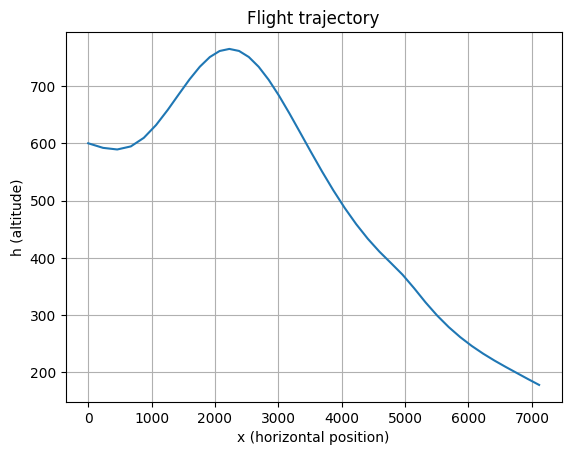

In [102]:
plt.figure()
plt.plot(res["x"], res["h"])
plt.xlabel("x (horizontal position)")
plt.ylabel("h (altitude)")
plt.title("Flight trajectory")
plt.grid()
plt.show()


In [103]:
def solve_ocp_debug(k_value=0):
    tf = 40
    N = 40
    dt = tf / N

    # Constants
    m = 4662
    g = 32.172
    delta = 0.03491
    A0 = 0.4456e5
    A1 = -0.2398e2
    A2 = 0.1442e-1
    rho = 0.2203e-2
    S = 0.1560e4
    C0 = 0.7125
    C1 = 6.0877
    umax = 0.05236
    alphamax = 0.3
    hR = 1000

    opti = ca.Opti()
    x = opti.variable(N+1)
    h = opti.variable(N+1)
    V = opti.variable(N+1)
    gamma = opti.variable(N+1)
    alpha = opti.variable(N+1)
    u = opti.variable(N)

    # Simplified wind (no spatial dependency for now)
    def wind_x(x_, k_): return 0
    def wind_h(x_, h_, k_): return 0

    def aircraft_ode(X, u_):
        x_, h_, V_, gamma_, alpha_ = ca.vertsplit(X)
        T = A0 + A1 * V_ + A2 * V_**2
        D = 0.5 * rho * S * V_**2
        L = 0.5 * rho * S * (C0 + C1 * alpha_) * V_**2
        V_safe = ca.fmax(V_, 1e-3)

        Wx = wind_x(x_, k_value)
        Wh = wind_h(x_, h_, k_value)

        # Disable wind gradient terms
        Wx_dot = 0
        Wh_dot = 0

        x_dot = V_ * ca.cos(gamma_) + Wx
        h_dot = V_ * ca.sin(gamma_) + Wh
        V_dot = T / m * ca.cos(alpha_ + delta) - D / m - g * ca.sin(gamma_)
        gamma_dot = T / (m * V_safe) * ca.sin(alpha_ + delta) + L / (m * V_safe) - g / V_safe * ca.cos(gamma_)
        alpha_dot = u_

        return ca.vertcat(x_dot, h_dot, V_dot, gamma_dot, alpha_dot)

    # Integrator
    X_sym = ca.MX.sym("X", 5)
    u_sym = ca.MX.sym("u")
    rhs = aircraft_ode(X_sym, u_sym)
    intg = ca.integrator("intg", "rk", {"x": X_sym, "p": u_sym, "ode": rhs}, {"tf": dt})

    # Boundary Conditions
    opti.subject_to(x[0] == 0)
    opti.subject_to(h[0] == 600)
    opti.subject_to(V[0] == 239.7)
    opti.subject_to(gamma[0] == -0.03925)
    opti.subject_to(alpha[0] == 0.1283)
    opti.subject_to(gamma[-1] == -0.05236)

    # Dynamics + Constraints
    for i in range(N):
        Xk = ca.vertcat(x[i], h[i], V[i], gamma[i], alpha[i])
        Uk = u[i]
        Xk_end = intg(x0=Xk, p=Uk)["xf"]
        X_next = ca.vertcat(x[i+1], h[i+1], V[i+1], gamma[i+1], alpha[i+1])
        diff = X_next - Xk_end

        # Relaxed defect constraint per component
        opti.subject_to(opti.bounded(-1e-1, diff[0], 1e-1))     # x
        opti.subject_to(opti.bounded(-1e-1, diff[1], 1e-1))     # h
        opti.subject_to(opti.bounded(-1e-1, diff[2], 1e-1))     # V
        opti.subject_to(opti.bounded(-1e-3, diff[3], 1e-3))     # gamma
        opti.subject_to(opti.bounded(-1e-3, diff[4], 1e-3))     # alpha

        opti.subject_to(ca.fabs(u[i]) <= umax)
        opti.subject_to(ca.fabs(alpha[i]) <= alphamax)

    # Objective
    J = dt * ca.sumsqr(h - hR)
    opti.minimize(J)

    # Initial guesses
    opti.set_initial(x, ca.linspace(0, 10000, N+1))
    opti.set_initial(h, 600)
    opti.set_initial(V, 239.7)
    opti.set_initial(gamma, -0.03925)
    opti.set_initial(alpha, 0.1283)
    opti.set_initial(u, 0)

    opti.solver("ipopt", {
        "expand": True,
        "print_time": True
    }, {
        "max_iter": 500,
        "tol": 1e-6,
        "print_level": 0,
        "linear_solver": "mumps",
        "hessian_approximation": "limited-memory",
    })


    try:
        sol = opti.solve()
    except RuntimeError as e:
        print("Infeasibilities:")
        opti.debug.show_infeasibilities()
        raise e

    return {
        "x": sol.value(x),
        "h": sol.value(h),
        "V": sol.value(V),
        "gamma": sol.value(gamma),
        "alpha": sol.value(alpha),
        "u": sol.value(u),
        "J": sol.value(J),
    }


In [104]:
res = solve_ocp_debug(k_value=1.0)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        6
Number of nonzeros in inequality constraint Jacobian.:     1080
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      245
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        6
Total number of inequality constraints...............:      280
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      200
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.5600000e+06 1.58e+01 1.00e+02   0.0 0.00e+00    -  0.00e+00 0.00e+00 

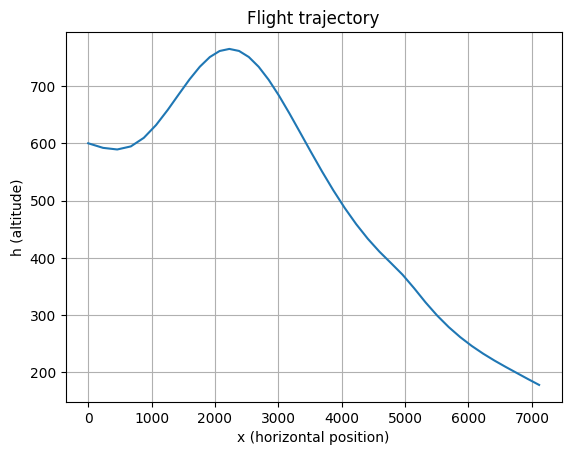

In [105]:
plt.figure()
plt.plot(res["x"], res["h"])
plt.xlabel("x (horizontal position)")
plt.ylabel("h (altitude)")
plt.title("Flight trajectory")
plt.grid()
plt.show()

## Smooth Good Winds Scaled

The wind model used in this scenario consists of smooth, differentiable expressions. The **horizontal wind component** is given by a Gaussian-type expression centered at $x = 2300$, while the **vertical wind component** is scaled linearly with altitude and follows a similar Gaussian spatial decay.

Specifically, the wind components are defined as:

$$
W_x(x) = k \left(1 - \exp\left(-\left(\frac{x - 2300}{500}\right)^2\right)\right)
$$

$$
W_h(x, h) = k \cdot \frac{h}{1000} \cdot \exp\left(-\left(\frac{x - 2300}{800}\right)^2\right)
$$

where $k$ is the wind intensity parameter.

In [183]:
def solve_ocp_full(k_value=1.0):
    tf = 40
    N = 40
    dt = tf / N

    # Aircraft and environment constants
    m = 4662
    g = 32.172
    delta = 0.03491
    A0 = 0.4456e5
    A1 = -0.2398e2
    A2 = 0.1442e-1
    rho = 0.2203e-2
    S = 0.1560e4
    C0 = 0.7125
    C1 = 6.0877
    umax = 0.05236
    alphamax = 0.3
    hR = 1000

    opti = ca.Opti()
    x = opti.variable(N+1)
    h = opti.variable(N+1)
    V = opti.variable(N+1)
    gamma = opti.variable(N+1)
    alpha = opti.variable(N+1)
    u = opti.variable(N)

    # Wind models with derivatives
    def wind_x_expr(x_, k_):
        return k_ * (1 - ca.exp(-((x_ - 2300)/500)**2))

    def wind_h_expr(x_, h_, k_):
        return k_ * (h_ / 1000.0) * ca.exp(-((x_ - 2300)/800)**2)

    x_sym = ca.MX.sym("x")
    h_sym = ca.MX.sym("h")
    Wx_expr = wind_x_expr(x_sym, k_value)
    Wh_expr = wind_h_expr(x_sym, h_sym, k_value)

    dWx_dx_fun = ca.Function("dWx_dx", [x_sym], [ca.gradient(Wx_expr, x_sym)])
    dWh_dx_fun = ca.Function("dWh_dx", [x_sym, h_sym], [ca.gradient(Wh_expr, x_sym)])
    dWh_dh_fun = ca.Function("dWh_dh", [x_sym, h_sym], [ca.gradient(Wh_expr, h_sym)])

    def wind_x(x_, k_):
        return wind_x_expr(x_, k_)

    def wind_h(x_, h_, k_):
        return wind_h_expr(x_, h_, k_)

    def aircraft_ode(X, u_):
        x_, h_, V_, gamma_, alpha_ = ca.vertsplit(X)
        T = A0 + A1 * V_ + A2 * V_**2
        D = 0.5 * rho * S * V_**2
        L = 0.5 * rho * S * (C0 + C1 * alpha_) * V_**2
        V_safe = ca.fmax(V_, 1e-3)

        Wx = wind_x(x_, k_value)
        Wh = wind_h(x_, h_, k_value)

        dWx_dx_val = dWx_dx_fun(x_)[0]
        dWh_dx_val = dWh_dx_fun(x_, h_)[0]
        dWh_dh_val = dWh_dh_fun(x_, h_)[0]

        x_dot = V_ * ca.cos(gamma_) + Wx
        h_dot = V_ * ca.sin(gamma_) + Wh

        Wx_dot = dWx_dx_val * x_dot
        Wh_dot = dWh_dx_val * x_dot + dWh_dh_val * h_dot

        V_dot = T / m * ca.cos(alpha_ + delta) - D / m - g * ca.sin(gamma_) \
                - (Wx_dot * ca.cos(gamma_) + Wh_dot * ca.sin(gamma_))

        gamma_dot = T / (m * V_safe) * ca.sin(alpha_ + delta) + L / (m * V_safe) \
                    - g / V_safe * ca.cos(gamma_) \
                    + (1 / V_safe) * (Wx_dot * ca.sin(gamma_) - Wh_dot * ca.cos(gamma_))

        alpha_dot = u_

        return ca.vertcat(x_dot, h_dot, V_dot, gamma_dot, alpha_dot)

    # Integrator
    X_sym = ca.MX.sym("X", 5)
    u_sym = ca.MX.sym("u")
    rhs = aircraft_ode(X_sym, u_sym)
    intg = ca.integrator("intg", "rk", {"x": X_sym, "p": u_sym, "ode": rhs}, {"tf": dt})

    # Initial conditions
    opti.subject_to(x[0] == 0)
    opti.subject_to(h[0] == 600)
    opti.subject_to(V[0] == 239.7)
    opti.subject_to(gamma[0] == -0.03925)
    opti.subject_to(alpha[0] == 0.1283)
    opti.subject_to(gamma[-1] == -0.05236)

    for i in range(N):
        Xk = ca.vertcat(x[i], h[i], V[i], gamma[i], alpha[i])
        Uk = u[i]
        Xk_end = intg(x0=Xk, p=Uk)["xf"]
        X_next = ca.vertcat(x[i+1], h[i+1], V[i+1], gamma[i+1], alpha[i+1])
        diff = X_next - Xk_end

        opti.subject_to(opti.bounded(-1e-1, diff[0], 1e-1))
        opti.subject_to(opti.bounded(-1e-1, diff[1], 1e-1))
        opti.subject_to(opti.bounded(-1e-1, diff[2], 1e-1))
        opti.subject_to(opti.bounded(-1e-3, diff[3], 1e-3))
        opti.subject_to(opti.bounded(-1e-3, diff[4], 1e-3))

        opti.subject_to(ca.fabs(u[i]) <= umax)
        opti.subject_to(ca.fabs(alpha[i]) <= alphamax)

    J = dt * ca.sumsqr(h - hR)
    opti.minimize(J)

    opti.set_initial(x, ca.linspace(0, 10000, N+1))
    opti.set_initial(h, 600)
    opti.set_initial(V, 239.7)
    opti.set_initial(gamma, -0.03925)
    opti.set_initial(alpha, 0.1283)
    opti.set_initial(u, 0)

    opti.solver("ipopt", {"expand": True}, {
        "max_iter": 500,
        "tol": 1e-6,
        "print_level": 5,
        "linear_solver": "mumps",
        "hessian_approximation": "limited-memory"
    })

    try:
        sol = opti.solve()
    except RuntimeError as e:
        print("Infeasibilities:")
        opti.debug.show_infeasibilities()
        raise e

    return {
        "x": sol.value(x),
        "h": sol.value(h),
        "V": sol.value(V),
        "gamma": sol.value(gamma),
        "alpha": sol.value(alpha),
        "u": sol.value(u),
        "J": sol.value(J),
    }

In [184]:
res_full = solve_ocp_full(k_value=1.0)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        6
Number of nonzeros in inequality constraint Jacobian.:     1320
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      245
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        6
Total number of inequality constraints...............:      280
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      200
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.5600000e+06 1.58e+01 1.00e+02   0.0 0.00e+00    -  0.00e+00 0.00e+00 

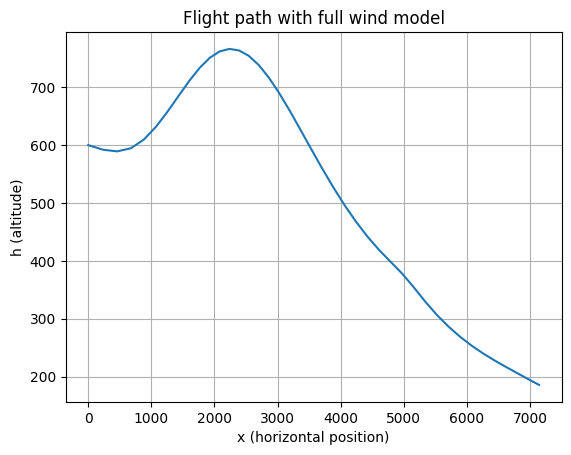

In [186]:
plt.figure()
plt.plot(res_full["x"], res_full["h"])
plt.xlabel("x (horizontal position)")
plt.ylabel("h (altitude)")
plt.title("Flight path with full wind model")
plt.grid()
plt.show()

## Real Winds, $q=6$, RK

In [190]:
def solve_ocp_full(k_value=1.0):
    tf = 40
    N = 40
    dt = tf / N

    # Aircraft and environment constants
    m = 4662
    g = 32.172
    delta = 0.03491
    A0 = 0.4456e5
    A1 = -0.2398e2
    A2 = 0.1442e-1
    rho = 0.2203e-2
    S = 0.1560e4
    C0 = 0.7125
    C1 = 6.0877
    umax = 0.05236
    alphamax = 0.3
    hR = 1000
    h_star = 1000

    a = 6e-8
    b = -4e-11
    c = -np.log(25 / 30.6) * 1e-12
    d = -8.02881e-8
    e = 6.28083e-11

    opti = ca.Opti()
    x = opti.variable(N+1)
    h = opti.variable(N+1)
    V = opti.variable(N+1)
    gamma = opti.variable(N+1)
    alpha = opti.variable(N+1)
    u = opti.variable(N)

    # Smooth step function
    def Smooth(x, x0, x1):
        t = (x - x0) / (x1 - x0 + 1e-6)
        return ca.if_else(x < x0, 0,
               ca.if_else(x > x1, 1, 6*t**5 - 15*t**4 + 10*t**3))

    # Piecewise A(x) from Eq. (14)
    def A_piecewise(x_):
        A1 = -50 + a * x_**3 + b * x_**4
        A2 = 0.025 * (x_ - 2300)
        A3 = 50 - a * (4600 - x_)**3 - b * (4600 - x_)**4
        A4 = 50
        s1 = Smooth(x_, 480, 520)
        s2 = Smooth(x_, 4080, 4120)
        s3 = Smooth(x_, 4580, 4620)
        B12 = (1 - s1)*A1 + s1*A2
        B23 = (1 - s2)*A2 + s2*A3
        B34 = (1 - s3)*A3 + s3*A4
        return ca.if_else(x_ <= 500, B12,
               ca.if_else(x_ <= 4100, B23,
               ca.if_else(x_ <= 4600, B34, A4)))

    # Piecewise B(x) from Eq. (16)
    def B_piecewise(x_):
        B1 = d * x_**3 + e * x_**4
        B2 = -51 * ca.exp(-c * (x_ - 2300)**4)
        B3 = d * (4600 - x_)**3 + e * (4600 - x_)**4
        B4 = 0
        s1 = Smooth(x_, 480, 520)
        s2 = Smooth(x_, 4080, 4120)
        s3 = Smooth(x_, 4580, 4620)
        B12 = (1 - s1)*B1 + s1*B2
        B23 = (1 - s2)*B2 + s2*B3
        B34 = (1 - s3)*B3 + s3*B4
        return ca.if_else(x_ <= 500, B12,
               ca.if_else(x_ <= 4100, B23,
               ca.if_else(x_ <= 4600, B34, B4)))

    # Wind functions
    def wind_x(x_):
        return k_value * A_piecewise(x_)

    def wind_h(x_, h_):
        return k_value * h_ / h_star * B_piecewise(x_)

    # Gradients
    x_sym = ca.MX.sym("x")
    h_sym = ca.MX.sym("h")
    Wx_expr = wind_x(x_sym)
    Wh_expr = wind_h(x_sym, h_sym)

    dWx_dx_fun = ca.Function("dWx_dx", [x_sym], [ca.gradient(Wx_expr, x_sym)])
    dWh_dx_fun = ca.Function("dWh_dx", [x_sym, h_sym], [ca.gradient(Wh_expr, x_sym)])
    dWh_dh_fun = ca.Function("dWh_dh", [x_sym, h_sym], [ca.gradient(Wh_expr, h_sym)])

    def aircraft_ode(X, u_):
        x_, h_, V_, gamma_, alpha_ = ca.vertsplit(X)
        T = A0 + A1 * V_ + A2 * V_**2
        D = 0.5 * rho * S * V_**2
        L = 0.5 * rho * S * (C0 + C1 * alpha_) * V_**2
        V_safe = ca.fmax(V_, 1e-3)

        Wx = wind_x(x_)
        Wh = wind_h(x_, h_)

        dWx_dx_val = dWx_dx_fun(x_)[0]
        dWh_dx_val = dWh_dx_fun(x_, h_)[0]
        dWh_dh_val = dWh_dh_fun(x_, h_)[0]

        x_dot = V_ * ca.cos(gamma_) + Wx
        h_dot = V_ * ca.sin(gamma_) + Wh

        Wx_dot = dWx_dx_val * x_dot
        Wh_dot = dWh_dx_val * x_dot + dWh_dh_val * h_dot

        V_dot = T / m * ca.cos(alpha_ + delta) - D / m - g * ca.sin(gamma_) \
                - (Wx_dot * ca.cos(gamma_) + Wh_dot * ca.sin(gamma_))

        gamma_dot = T / (m * V_safe) * ca.sin(alpha_ + delta) + L / (m * V_safe) \
                    - g / V_safe * ca.cos(gamma_) \
                    + (1 / V_safe) * (Wx_dot * ca.sin(gamma_) - Wh_dot * ca.cos(gamma_))

        alpha_dot = u_

        return ca.vertcat(x_dot, h_dot, V_dot, gamma_dot, alpha_dot)

    X_sym = ca.MX.sym("X", 5)
    u_sym = ca.MX.sym("u")
    rhs = aircraft_ode(X_sym, u_sym)
    intg = ca.integrator("intg", "rk", {"x": X_sym, "p": u_sym, "ode": rhs}, {"tf": dt})

    opti.subject_to(x[0] == 0)
    opti.subject_to(h[0] == 600)
    opti.subject_to(V[0] == 239.7)
    opti.subject_to(gamma[0] == -0.03925)
    opti.subject_to(alpha[0] == 0.1283)
    opti.subject_to(gamma[-1] == -0.05236)

    for i in range(N):
        Xk = ca.vertcat(x[i], h[i], V[i], gamma[i], alpha[i])
        Uk = u[i]
        Xk_end = intg(x0=Xk, p=Uk)["xf"]
        X_next = ca.vertcat(x[i+1], h[i+1], V[i+1], gamma[i+1], alpha[i+1])
        diff = X_next - Xk_end

        opti.subject_to(opti.bounded(-1e-1, diff[0], 1e-1))
        opti.subject_to(opti.bounded(-1e-1, diff[1], 1e-1))
        opti.subject_to(opti.bounded(-1e-1, diff[2], 1e-1))
        opti.subject_to(opti.bounded(-1e-3, diff[3], 1e-3))
        opti.subject_to(opti.bounded(-1e-3, diff[4], 1e-3))

        opti.subject_to(ca.fabs(u[i]) <= umax)
        opti.subject_to(ca.fabs(alpha[i]) <= alphamax)

    J = dt * ca.sumsqr(ca.vertcat(*[(hR - h[i])**3 for i in range(N+1)]))
    opti.minimize(J)

    opti.set_initial(x, ca.linspace(0, 10000, N+1))
    opti.set_initial(h, 600)
    opti.set_initial(V, 239.7)
    opti.set_initial(gamma, -0.03925)
    opti.set_initial(alpha, 0.1283)
    opti.set_initial(u, 0)

    opti.solver("ipopt", {"expand": True}, {
        "max_iter": 500,
        "tol": 1e-6,
        "print_level": 5,
        "linear_solver": "mumps",
        "hessian_approximation": "limited-memory"
    })

    try:
        sol = opti.solve()
    except RuntimeError as e:
        print("Infeasibilities:")
        opti.debug.show_infeasibilities()
        raise e

    return {
        "x": sol.value(x),
        "h": sol.value(h),
        "V": sol.value(V),
        "gamma": sol.value(gamma),
        "alpha": sol.value(alpha),
        "u": sol.value(u),
        "J": sol.value(J),
    }


In [ ]:
res1 = solve_ocp_full(k_value=1.0)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        6
Number of nonzeros in inequality constraint Jacobian.:     1320
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      245
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        6
Total number of inequality constraints...............:      280
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      200
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.6793600e+17 6.58e+01 6.14e+05   0.0 0.00e+00    -  0.00e+00 0.00e+00 

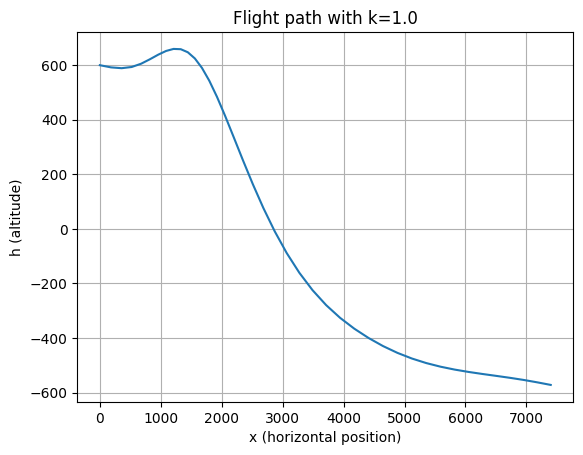

In [164]:
plt.figure()
plt.plot(res1["x"], res1["h"])
plt.xlabel("x (horizontal position)")
plt.ylabel("h (altitude)")
plt.title("Flight path with k=1.0")
plt.grid()
plt.show()

### Real Winds, RK, $q=2$

In [ ]:
def solve_ocp_full(k_value=1.0):
    tf = 40
    N = 40
    dt = tf / N

    # Aircraft and environment constants
    m = 4662
    g = 32.172
    delta = 0.03491
    A0 = 0.4456e5
    A1 = -0.2398e2
    A2 = 0.1442e-1
    rho = 0.2203e-2
    S = 0.1560e4
    C0 = 0.7125
    C1 = 6.0877
    umax = 0.05236
    alphamax = 0.3
    hR = 1000
    h_star = 1000

    a = 6e-8
    b = -4e-11
    c = -np.log(25 / 30.6) * 1e-12
    d = -8.02881e-8
    e = 6.28083e-11

    opti = ca.Opti()
    x = opti.variable(N+1)
    h = opti.variable(N+1)
    V = opti.variable(N+1)
    gamma = opti.variable(N+1)
    alpha = opti.variable(N+1)
    u = opti.variable(N)

    # Smooth step function
    def Smooth(x, x0, x1):
        t = (x - x0) / (x1 - x0 + 1e-6)
        return ca.if_else(x < x0, 0,
               ca.if_else(x > x1, 1, 6*t**5 - 15*t**4 + 10*t**3))

    # Piecewise A(x) from Eq. (14)
    def A_piecewise(x_):
        A1 = -50 + a * x_**3 + b * x_**4
        A2 = 0.025 * (x_ - 2300)
        A3 = 50 - a * (4600 - x_)**3 - b * (4600 - x_)**4
        A4 = 50
        s1 = Smooth(x_, 480, 520)
        s2 = Smooth(x_, 4080, 4120)
        s3 = Smooth(x_, 4580, 4620)
        B12 = (1 - s1)*A1 + s1*A2
        B23 = (1 - s2)*A2 + s2*A3
        B34 = (1 - s3)*A3 + s3*A4
        return ca.if_else(x_ <= 500, B12,
               ca.if_else(x_ <= 4100, B23,
               ca.if_else(x_ <= 4600, B34, A4)))

    # Piecewise B(x) from Eq. (16)
    def B_piecewise(x_):
        B1 = d * x_**3 + e * x_**4
        B2 = -51 * ca.exp(-c * (x_ - 2300)**4)
        B3 = d * (4600 - x_)**3 + e * (4600 - x_)**4
        B4 = 0
        s1 = Smooth(x_, 480, 520)
        s2 = Smooth(x_, 4080, 4120)
        s3 = Smooth(x_, 4580, 4620)
        B12 = (1 - s1)*B1 + s1*B2
        B23 = (1 - s2)*B2 + s2*B3
        B34 = (1 - s3)*B3 + s3*B4
        return ca.if_else(x_ <= 500, B12,
               ca.if_else(x_ <= 4100, B23,
               ca.if_else(x_ <= 4600, B34, B4)))

    # Wind functions
    def wind_x(x_):
        return k_value * A_piecewise(x_)

    def wind_h(x_, h_):
        return k_value * h_ / h_star * B_piecewise(x_)

    # Gradients
    x_sym = ca.MX.sym("x")
    h_sym = ca.MX.sym("h")
    Wx_expr = wind_x(x_sym)
    Wh_expr = wind_h(x_sym, h_sym)

    dWx_dx_fun = ca.Function("dWx_dx", [x_sym], [ca.gradient(Wx_expr, x_sym)])
    dWh_dx_fun = ca.Function("dWh_dx", [x_sym, h_sym], [ca.gradient(Wh_expr, x_sym)])
    dWh_dh_fun = ca.Function("dWh_dh", [x_sym, h_sym], [ca.gradient(Wh_expr, h_sym)])

    def aircraft_ode(X, u_):
        x_, h_, V_, gamma_, alpha_ = ca.vertsplit(X)
        T = A0 + A1 * V_ + A2 * V_**2
        D = 0.5 * rho * S * V_**2
        L = 0.5 * rho * S * (C0 + C1 * alpha_) * V_**2
        V_safe = ca.fmax(V_, 1e-3)

        Wx = wind_x(x_)
        Wh = wind_h(x_, h_)

        dWx_dx_val = dWx_dx_fun(x_)[0]
        dWh_dx_val = dWh_dx_fun(x_, h_)[0]
        dWh_dh_val = dWh_dh_fun(x_, h_)[0]

        x_dot = V_ * ca.cos(gamma_) + Wx
        h_dot = V_ * ca.sin(gamma_) + Wh

        Wx_dot = dWx_dx_val * x_dot
        Wh_dot = dWh_dx_val * x_dot + dWh_dh_val * h_dot

        V_dot = T / m * ca.cos(alpha_ + delta) - D / m - g * ca.sin(gamma_) \
                - (Wx_dot * ca.cos(gamma_) + Wh_dot * ca.sin(gamma_))

        gamma_dot = T / (m * V_safe) * ca.sin(alpha_ + delta) + L / (m * V_safe) \
                    - g / V_safe * ca.cos(gamma_) \
                    + (1 / V_safe) * (Wx_dot * ca.sin(gamma_) - Wh_dot * ca.cos(gamma_))

        alpha_dot = u_

        return ca.vertcat(x_dot, h_dot, V_dot, gamma_dot, alpha_dot)

    X_sym = ca.MX.sym("X", 5)
    u_sym = ca.MX.sym("u")
    rhs = aircraft_ode(X_sym, u_sym)
    intg = ca.integrator("intg", "rk", {"x": X_sym, "p": u_sym, "ode": rhs}, {"tf": dt})

    opti.subject_to(x[0] == 0)
    opti.subject_to(h[0] == 600)
    opti.subject_to(V[0] == 239.7)
    opti.subject_to(gamma[0] == -0.03925)
    opti.subject_to(alpha[0] == 0.1283)
    opti.subject_to(gamma[-1] == -0.05236)

    for i in range(N):
        Xk = ca.vertcat(x[i], h[i], V[i], gamma[i], alpha[i])
        Uk = u[i]
        Xk_end = intg(x0=Xk, p=Uk)["xf"]
        X_next = ca.vertcat(x[i+1], h[i+1], V[i+1], gamma[i+1], alpha[i+1])
        diff = X_next - Xk_end

        opti.subject_to(opti.bounded(-1e-1, diff[0], 1e-1))
        opti.subject_to(opti.bounded(-1e-1, diff[1], 1e-1))
        opti.subject_to(opti.bounded(-1e-1, diff[2], 1e-1))
        opti.subject_to(opti.bounded(-1e-3, diff[3], 1e-3))
        opti.subject_to(opti.bounded(-1e-3, diff[4], 1e-3))

        opti.subject_to(ca.fabs(u[i]) <= umax)
        opti.subject_to(ca.fabs(alpha[i]) <= alphamax)

    J = dt * ca.sumsqr(ca.vertcat(*[(hR - h[i]) for i in range(N+1)]))
    opti.minimize(J)

    opti.set_initial(x, ca.linspace(0, 10000, N+1))
    opti.set_initial(h, 600)
    opti.set_initial(V, 239.7)
    opti.set_initial(gamma, -0.03925)
    opti.set_initial(alpha, 0.1283)
    opti.set_initial(u, 0)

    opti.solver("ipopt", {"expand": True}, {
        "max_iter": 500,
        "tol": 1e-6,
        "print_level": 5,
        "linear_solver": "mumps",
        "hessian_approximation": "limited-memory"
    })

    try:
        sol = opti.solve()
    except RuntimeError as e:
        print("Infeasibilities:")
        opti.debug.show_infeasibilities()
        raise e

    return {
        "x": sol.value(x),
        "h": sol.value(h),
        "V": sol.value(V),
        "gamma": sol.value(gamma),
        "alpha": sol.value(alpha),
        "u": sol.value(u),
        "J": sol.value(J),
    }

In [159]:
res_real = solve_ocp_full(k_value=2)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        6
Number of nonzeros in inequality constraint Jacobian.:     1320
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      245
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        6
Total number of inequality constraints...............:      280
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:      200
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.5600000e+06 1.16e+02 1.00e+02   0.0 0.00e+00    -  0.00e+00 0.00e+00 

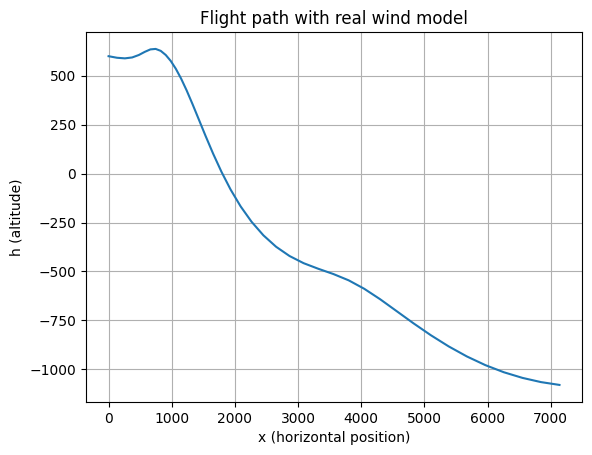

In [160]:
plt.figure()
plt.plot(res_real["x"], res_real["h"])
plt.xlabel("x (horizontal position)")
plt.ylabel("h (altitude)")
plt.title("Flight path with real wind model")
plt.grid()
plt.show()